In [29]:
import nltk

from nltk.tokenize import word_tokenize
import spacy
import pandas as pd
import re, glob
import pandas as pd
import spacy
import nltk 
nltk.download('punkt')
import requests
import wikipedia
import wptools
import os
from nltk.metrics import ConfusionMatrix
from nltk.parse.stanford import StanfordDependencyParser
import seaborn as sns
import matplotlib.pyplot as plt

nlp = spacy.load("en_core_web_sm")
DATA_DIR = "./"
OUTPUT_PATH = './data'

[nltk_data] Downloading package punkt to /home/manil/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Data Collection

In [33]:
def scraper(src, n): #function to get text from web
    count = 0 # counter to count that the loop runs n times only
    try:
        page = wikipedia.page(src) #wikipedia page for the item
        l = page.links #get all links from the page
        
        for link in l: # loop to extract text and make n text files from these wiki links in the said wikipedia page
            if count < n+1:
                p = wikipedia.page(title = link)
                file_name = "{}.txt".format(p.title)
                complete_path = os.path.join(OUTPUT_PATH, file_name)
                with open(complete_path, "w", encoding= 'utf-8' ) as text_file: # writing text into text files
                    text_file.write(p.summary)
                count = count +1    
            else:
                break     
    except Exception as e:
        pass

In [116]:
topic_list = ["human rights", "Pyramids", "Classical conditioning", "Great Barrier Reef"]
for topic in topic_list:
    scraper(topic, 30)

/home/manil/miniconda3/envs/dscourse/lib/python3.7/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /home/manil/miniconda3/envs/dscourse/lib/python3.7/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


### Sentence segmentation

In [117]:
def segment_data(directory):
  """ This function takes a directory (str) as an input 
  merges all files and performs sentence segmentation with spacy and nltk.
  Returns: DataFrame with columns :
  [original_text,shared_sentences,unique_to_spacy,unique_to_nltk,nltk_segmentation,spacy_segmentation]
  """
  content = []
  for entry in glob.glob(os.path.join(directory, "*.txt")): # reading each file in the object
      with open(entry,'r') as f: # opening each file
        summaries = f.read()
        content.append(summaries) # append text data into content list
        string_text = ' '.join(content) # converting all list elements of content object into one long string to be accepted by spacy and nltk

  nlp.max_length = 20000000
  spacy_sents1 = [sent.text for sent in nlp(string_text).sents] # creating list of segmented sentences of spacy
  sentences_nltk = nltk.sent_tokenize(string_text) # segmentation nltk

  df = pd.DataFrame()
  one_spacy = pd.Series(spacy_sents1)
  one_nltk = pd.Series(sentences_nltk)

  shared = one_spacy[one_spacy.isin(one_nltk)] # filtering only shared sentences that are segmented the same by the two modules
  unique_to_spacy = one_spacy[~one_spacy.isin(one_nltk)] # filtering unique sentences segmented by spacy
  unique_to_nltk = one_nltk[~one_nltk.isin(one_spacy)] # filtering unique sentences segmented by spacy
  df['shared_sentences'] = shared
  df['unique_to_spacy'] = unique_to_spacy.reset_index(drop=True)
  df['unique_to_nltk'] = unique_to_nltk.reset_index(drop=True)
  df['nltk_segmentation']  = one_nltk.reset_index(drop=True)
  df['spacy_segmentation'] = one_spacy.reset_index(drop=True)
  df = pd.concat([pd.Series(string_text, name='original_text'), df], axis=1)
  return df

In [118]:
df = segment_data(OUTPUT_PATH)
df.to_csv('./segmentation_data.csv', index=False)

In [8]:
df = pd.read_csv("./segmentation_data.csv")

In [9]:
print("Number of shared sentences", df["shared_sentences"].count())
print("Number of sentences unique to nltk", df["unique_to_nltk"].count())
print("Number of sentences unique to spacy", df["unique_to_spacy"].count())

Number of shared sentences 288
Number of sentences unique to nltk 74
Number of sentences unique to spacy 105


### Tokenisation & PosTag

In [10]:
df = pd.read_csv("./segmentation_data.csv")

Set of unique tokens and their respective size

In [11]:
unsegmented_text= str(df['original_text'][0]).lower() # the original text without sentence segmentation
unsegmented_text_clean = re.sub(r'[\s+|\n+]', ' ', unsegmented_text).strip() # remove linebreaks and extra spaces from text before tokenizing

spacy_token_list = [token.text for token in nlp(unsegmented_text_clean)] # get all tokens in the text using spacy
nltk_token_list = nltk.word_tokenize(unsegmented_text_clean) # get all tokens in the text using nltk

uniq_token_nltk = set(nltk_token_list) # remove repetitions by converting to set for nltk
uniq_token_spacy = set(spacy_token_list) # remove repetitions by converting to set for spacy
print("Set of unique tokens (Spacy)", list(uniq_token_spacy)[:20])
print("Set of unique tokens (nltk)", list(uniq_token_nltk)[:20])

Set of unique tokens (Spacy) ['napoleon', 'adjusts', 'existential', 'defined', 'graze', 'assembly', 'own', 'coasts', 'intention', 'jurassic', 'class', 'astronomical', 'extremely', 'carving', 'least', 'outcome', 'diagnosed', 'g.', 'participating', 'cruise']
Set of unique tokens (nltk) ['napoleon', 'adjusts', 'existential', 'defined', 'graze', 'assembly', 'own', 'coasts', 'intention', 'jurassic', 'class', 'astronomical', 'extremely', 'carving', 'least', 'outcome', 'diagnosed', 'g.', 'participating', 'hand—and']


In [12]:
size_vocab_nltk = len(uniq_token_nltk) # number of unique tokens identified by nltk in unsegmented text
size_vocab_spacy = len(uniq_token_spacy) # number of unique tokens identified by spacy in unsegmented text
print("Size of vocab (Spacy) :", size_vocab_spacy)
print("Size of vocab (nltk) :", size_vocab_nltk)

Size of vocab (Spacy) : 3235
Size of vocab (nltk) : 3270


Intersection of these two vocabularies

In [13]:
common_tokens_noseg = uniq_token_nltk.intersection(uniq_token_spacy) # common tokens identified by both spacy and nltk libraries
print(list(common_tokens_noseg)[:50])

['napoleon', 'adjusts', 'existential', 'defined', 'graze', 'assembly', 'own', 'coasts', 'intention', 'jurassic', 'class', 'astronomical', 'extremely', 'carving', 'least', 'outcome', 'diagnosed', 'g.', 'participating', 'cruise', 'organism', 'rodents', 'government', 'uncertainty', 'practice', 'deepwater', 'mattock', 'f.', 'nns', 'chornovol', 'exceptions', 'aspects', 'he', 'distraction', 'strait', '08:00', 'seen', 'turn', 'powers', 'malacalcyonacea', '1861–1865', 'apology', 'already', 'a.m.', '2000', 'attended', 'advanced', 'erectus', '2005', 'perception']


Now we will extract, sharedTokensInSentences, but we will also at the same time extract the pos-tags for each library to ease the processing later

In [14]:
# Create both tokenisations in sentences
spacy_tokens_sentences  = []
nltk_tokens_sentences = []
shared_token_in_sentences = []
for sentence in df['shared_sentences']: # loop to get tokens after sentence segmentation 
    segmented_text_clean = re.sub(r'[\s+|\n+]', ' ', str(sentence)).strip()
    spacy_segm = [token for token in nlp(str(sentence))]
    nltk_segm = nltk.pos_tag(nltk.word_tokenize(str(sentence)), tagset='universal')
    spacy_tokens_sentences.append(spacy_segm)
    nltk_tokens_sentences.append(nltk_segm)

In [15]:
# Extract shared tokens as well as each of nltk and spacy tags
for i, sent in enumerate(spacy_tokens_sentences):
    for token in sent:
        # Split nltk postag list into 2, one for token and one for tag
        nltk_token_tag = list(zip(*nltk_tokens_sentences[i]))
        if token.text in nltk_token_tag[0]:
            # Lookup for token index in nltk token list
            nltk_tag = nltk_token_tag[1][nltk_token_tag[0].index(token.text)]
            shared_token_in_sentences.append((token.text, token.pos_, nltk_tag))

Set of shared tokens in sentences

In [16]:
print(set(list(zip(*shared_token_in_sentences))[0]))

{'adjusts', 'existential', 'defined', 'Established', 'West', 'Barbara', 'coasts', 'intention', 'class', 'carving', 'least', 'outcome', 'diagnosed', 'participating', 'organism', 'government', 'uncertainty', 'practice', 'mattock', 'Terminal', 'exceptions', 'aspects', 'he', 'Gaja', 'British', '08:00', 'seen', 'turn', 'powers', 'apology', 'already', 'Ban', '2000', 'Squire', 'attended', 'advanced', 'erectus', '2005', 'perception', 'physically', 'experienced', 'shiploader', 'independence', 'process', 'rail', 'Kishinev', 'input', 'modeling', 'km', 'forgetful', 'Eastern', 'cultivated', 'encrusting', 'second', 'treatise', 'evening', 'orders', 'Global', 'lead', 'inability', 'nothing', '2014', 'consequences', 'related', 'retained', 'strategically', 'welfare', 'meaning', 'fibres', 'threat', 'pressure', 'Verkhovna', 'For', 'four', 'Many', 'increased', 'did', 'As', 'or', '2015', 'Birmingham', '1954', 'top', 'professor', 'city', 'promise', 'larger', 'relationships', 'management', 'culture', 'initiall

Get the number of times & ratio for which each token is assigned to the same tag by both libraries

In [17]:
from collections import defaultdict, Counter
token_count = Counter(list(zip(*shared_token_in_sentences))[0])
agreement = defaultdict(int)
for token in shared_token_in_sentences :
    if token[1]==token[2]:
        agreement[token[0]]+=1

print("Number of times spacy and nltk agree for each token: ", agreement)
ratios = {k:agreement[k]/token_count[k] for k in agreement}
print("Ratio of agreement: ", ratios)

Number of times spacy and nltk agree for each token:  defaultdict(<class 'int'>, {'The': 52, '2005': 2, 'held': 14, 'between': 15, '14': 3, '16': 2, 'a': 122, 'summit': 1, 'meeting': 1, 'the': 414, '2000': 1, 'which': 23, 'led': 3, 'of': 304, 'Representatives': 1, 'including': 13, 'nearly': 1, '200': 2, 'leaders': 1, 'then': 3, '191': 1, 'member': 3, 'states': 2, 'met': 1, 'in': 155, 'for': 40, 'what': 4, 'described': 4, 'opportunity': 1, 'take': 3, 'bold': 1, 'decisions': 1, 'areas': 2, 'development': 3, 'security': 1, 'human': 10, 'rights': 1, 'reform': 1, 'Adzes': 1, 'used': 10, 'They': 7, 'smoothing': 1, 'carving': 1, 'wood': 2, 'hand': 3, 'woodworking': 1, 'hoe': 1, 'agriculture': 1, 'horticulture': 1, 'Two': 2, 'basic': 1, 'forms': 1, 'an': 17, 'adze': 3, 'tool': 3, 'with': 28, 'one': 10, 'foot': 2, 'capable': 2, 'powerful': 1, 'swings': 1, 'using': 1, 'hands': 1, 'edge': 1, 'usually': 4, 'striking': 2, 'at': 23, 'shin': 1, 'level': 4, 'A': 8, 'similar': 4, 'called': 5, 'mattock'

Frequency mapping for each PosTag

Percentages for spacy

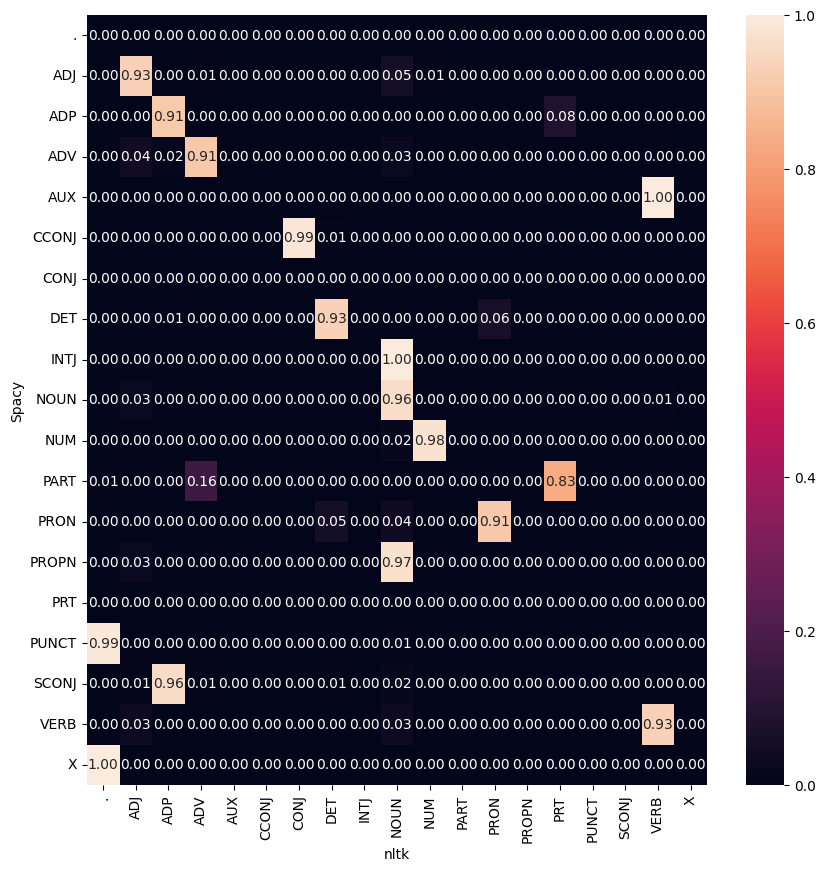

In [64]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(list(zip(*shared_token_in_sentences))[1], list(zip(*shared_token_in_sentences))[2], normalize="true")
cols = sorted(list(set(list(zip(*shared_token_in_sentences))[1]+list(zip(*shared_token_in_sentences))[2])))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=cols, yticklabels=cols)
plt.ylabel('Spacy')
plt.xlabel('nltk')
plt.show(block=False)

Percentages for nltk

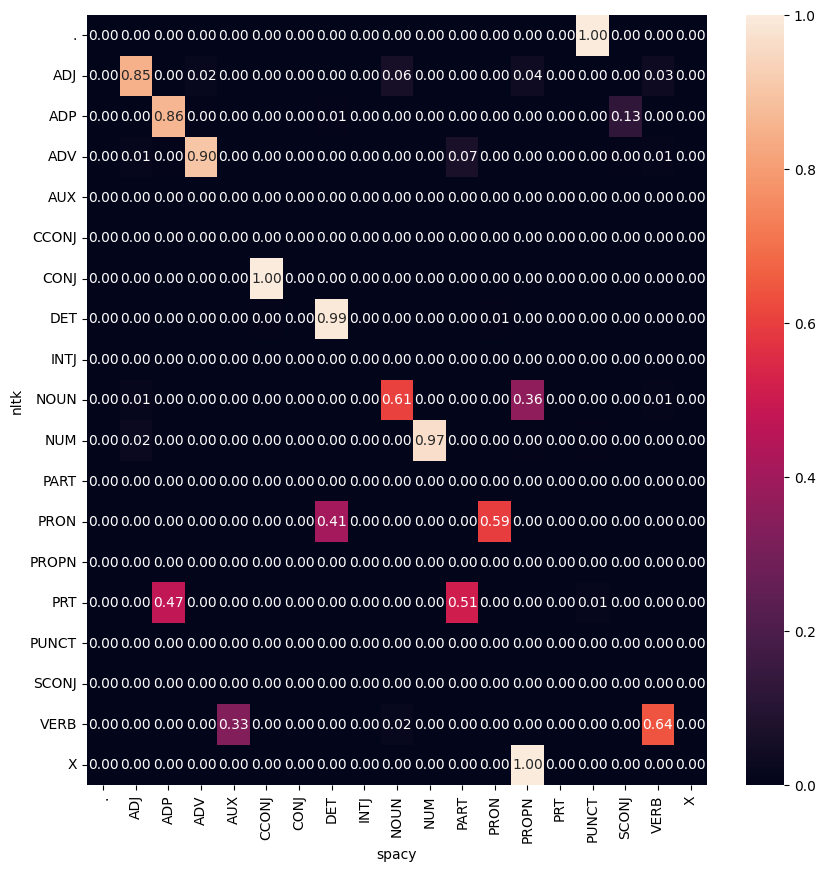

In [66]:
cm = confusion_matrix(list(zip(*shared_token_in_sentences))[2], list(zip(*shared_token_in_sentences))[1], normalize="true")
cols = sorted(list(set(list(zip(*shared_token_in_sentences))[1]+list(zip(*shared_token_in_sentences))[2])))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=cols, yticklabels=cols)
plt.ylabel('nltk')
plt.xlabel('spacy')
plt.show(block=False)

### Bonus

### Agreement on dependency relations

In [19]:
!unzip ./stanford-corenlp-4.2.2.zip

Archive:  ./stanford-corenlp-4.2.2.zip
replace stanford-corenlp-4.2.2/patterns/names.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [20]:
jar_path = './stanford-corenlp-4.2.2/stanford-corenlp-4.2.2.jar'

# Path to CoreNLP model jar
models_jar_path = './stanford-corenlp-4.2.2-models-english.jar'

dependency_parser = StanfordDependencyParser(path_to_jar=jar_path, path_to_models_jar=models_jar_path)

/home/manil/miniconda3/envs/dscourse/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The StanfordDependencyParser will be deprecated
Please use nltk.parse.corenlp.CoreNLPDependencyParser instead.
  


In [67]:
# nltk dependency parsing (based on Stanford parser)
nltk_dep_sentences = []
for sentence in df['shared_sentences']: 
    segmented_text_clean = re.sub(r'[\s+|\n+]', ' ', str(sentence)).strip()
    nltk_segm = dependency_parser.raw_parse(str(sentence))
    dependency = nltk_segm.__next__()
    nltk_dep_sentences.append([(link[0][0], link[1], link[2][0]) for link in list(dependency.triples())])

In [95]:
shared_rel_in_sentences = []
for i, sent in enumerate(spacy_tokens_sentences):
    for token in sent:
        # Split nltk dependency list into 3 lists:
        # 0: head, 1: relation, 2:governee
        nltk_deps = list(zip(*nltk_dep_sentences[i]))
        if len(nltk_deps) >= 3:
            if token.text in nltk_deps[2] and token.head.text in nltk_deps[0]:
                rel_idx = nltk_deps[2].index(token.text)
                nltk_rel = nltk_deps[1][rel_idx]
                shared_rel_in_sentences.append((token.text, token.head.text, nltk_rel, token.dep_))
            else:
                # if spacy identified one relation and nltk didnt we mark the relation as NLTKNOREL
                shared_rel_in_sentences.append((token.text, token.head.text, "NLTKNOREL", token.dep_))

Frequency mapping for each dependency

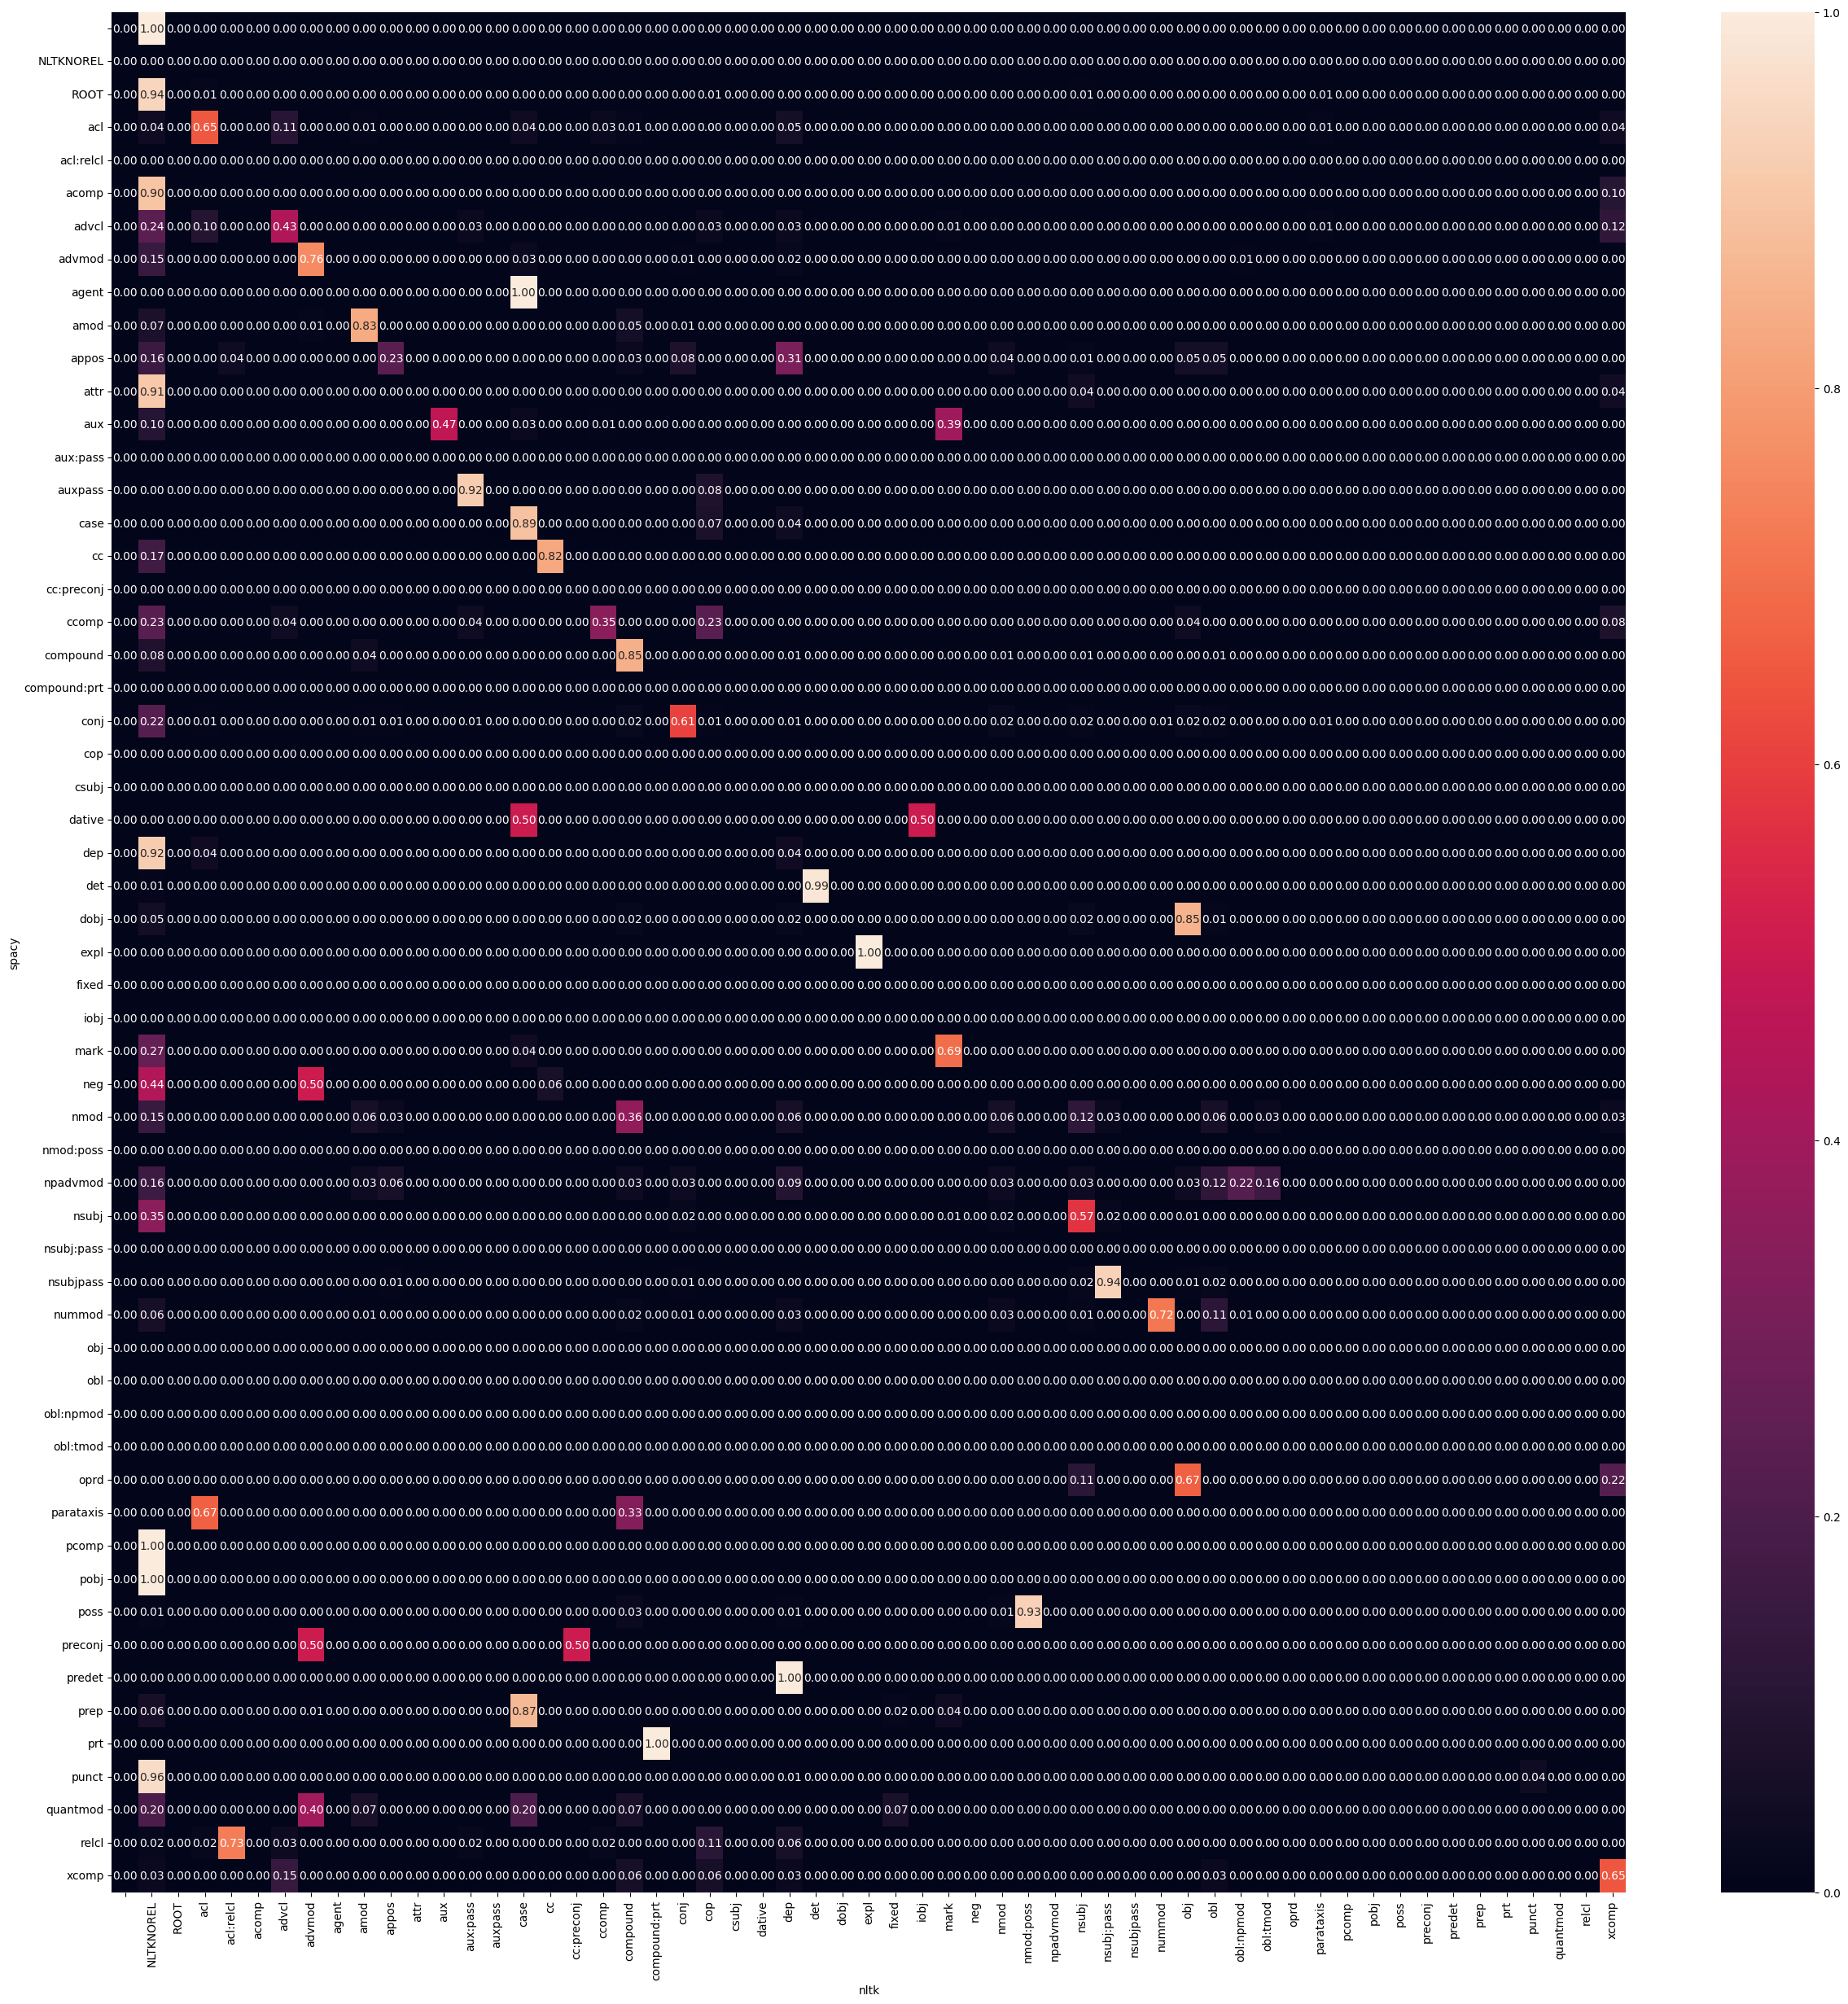

In [97]:
cm = confusion_matrix(list(zip(*shared_rel_in_sentences))[3], list(zip(*shared_rel_in_sentences))[2], normalize="true")
cols = sorted(list(set(list(zip(*shared_rel_in_sentences))[2]+list(zip(*shared_rel_in_sentences))[3])))
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=cols, yticklabels=cols)

plt.ylabel('spacy')
plt.xlabel('nltk')
plt.show(block=False)

In [98]:
not_in_spacy_rels = []
spacy_udrel_only = [ [(token.head.text, token.dep_, token.text)  for token in sent ] for sent in spacy_tokens_sentences ]
for i, sent in enumerate(nltk_dep_sentences):
    for relation in sent:
        # check if a relation is in spacy but not nltk
        if not relation in spacy_udrel_only[i]:
                not_in_spacy_rels.append((relation[2], relation[0], relation[1], "SPACYNOREL"))

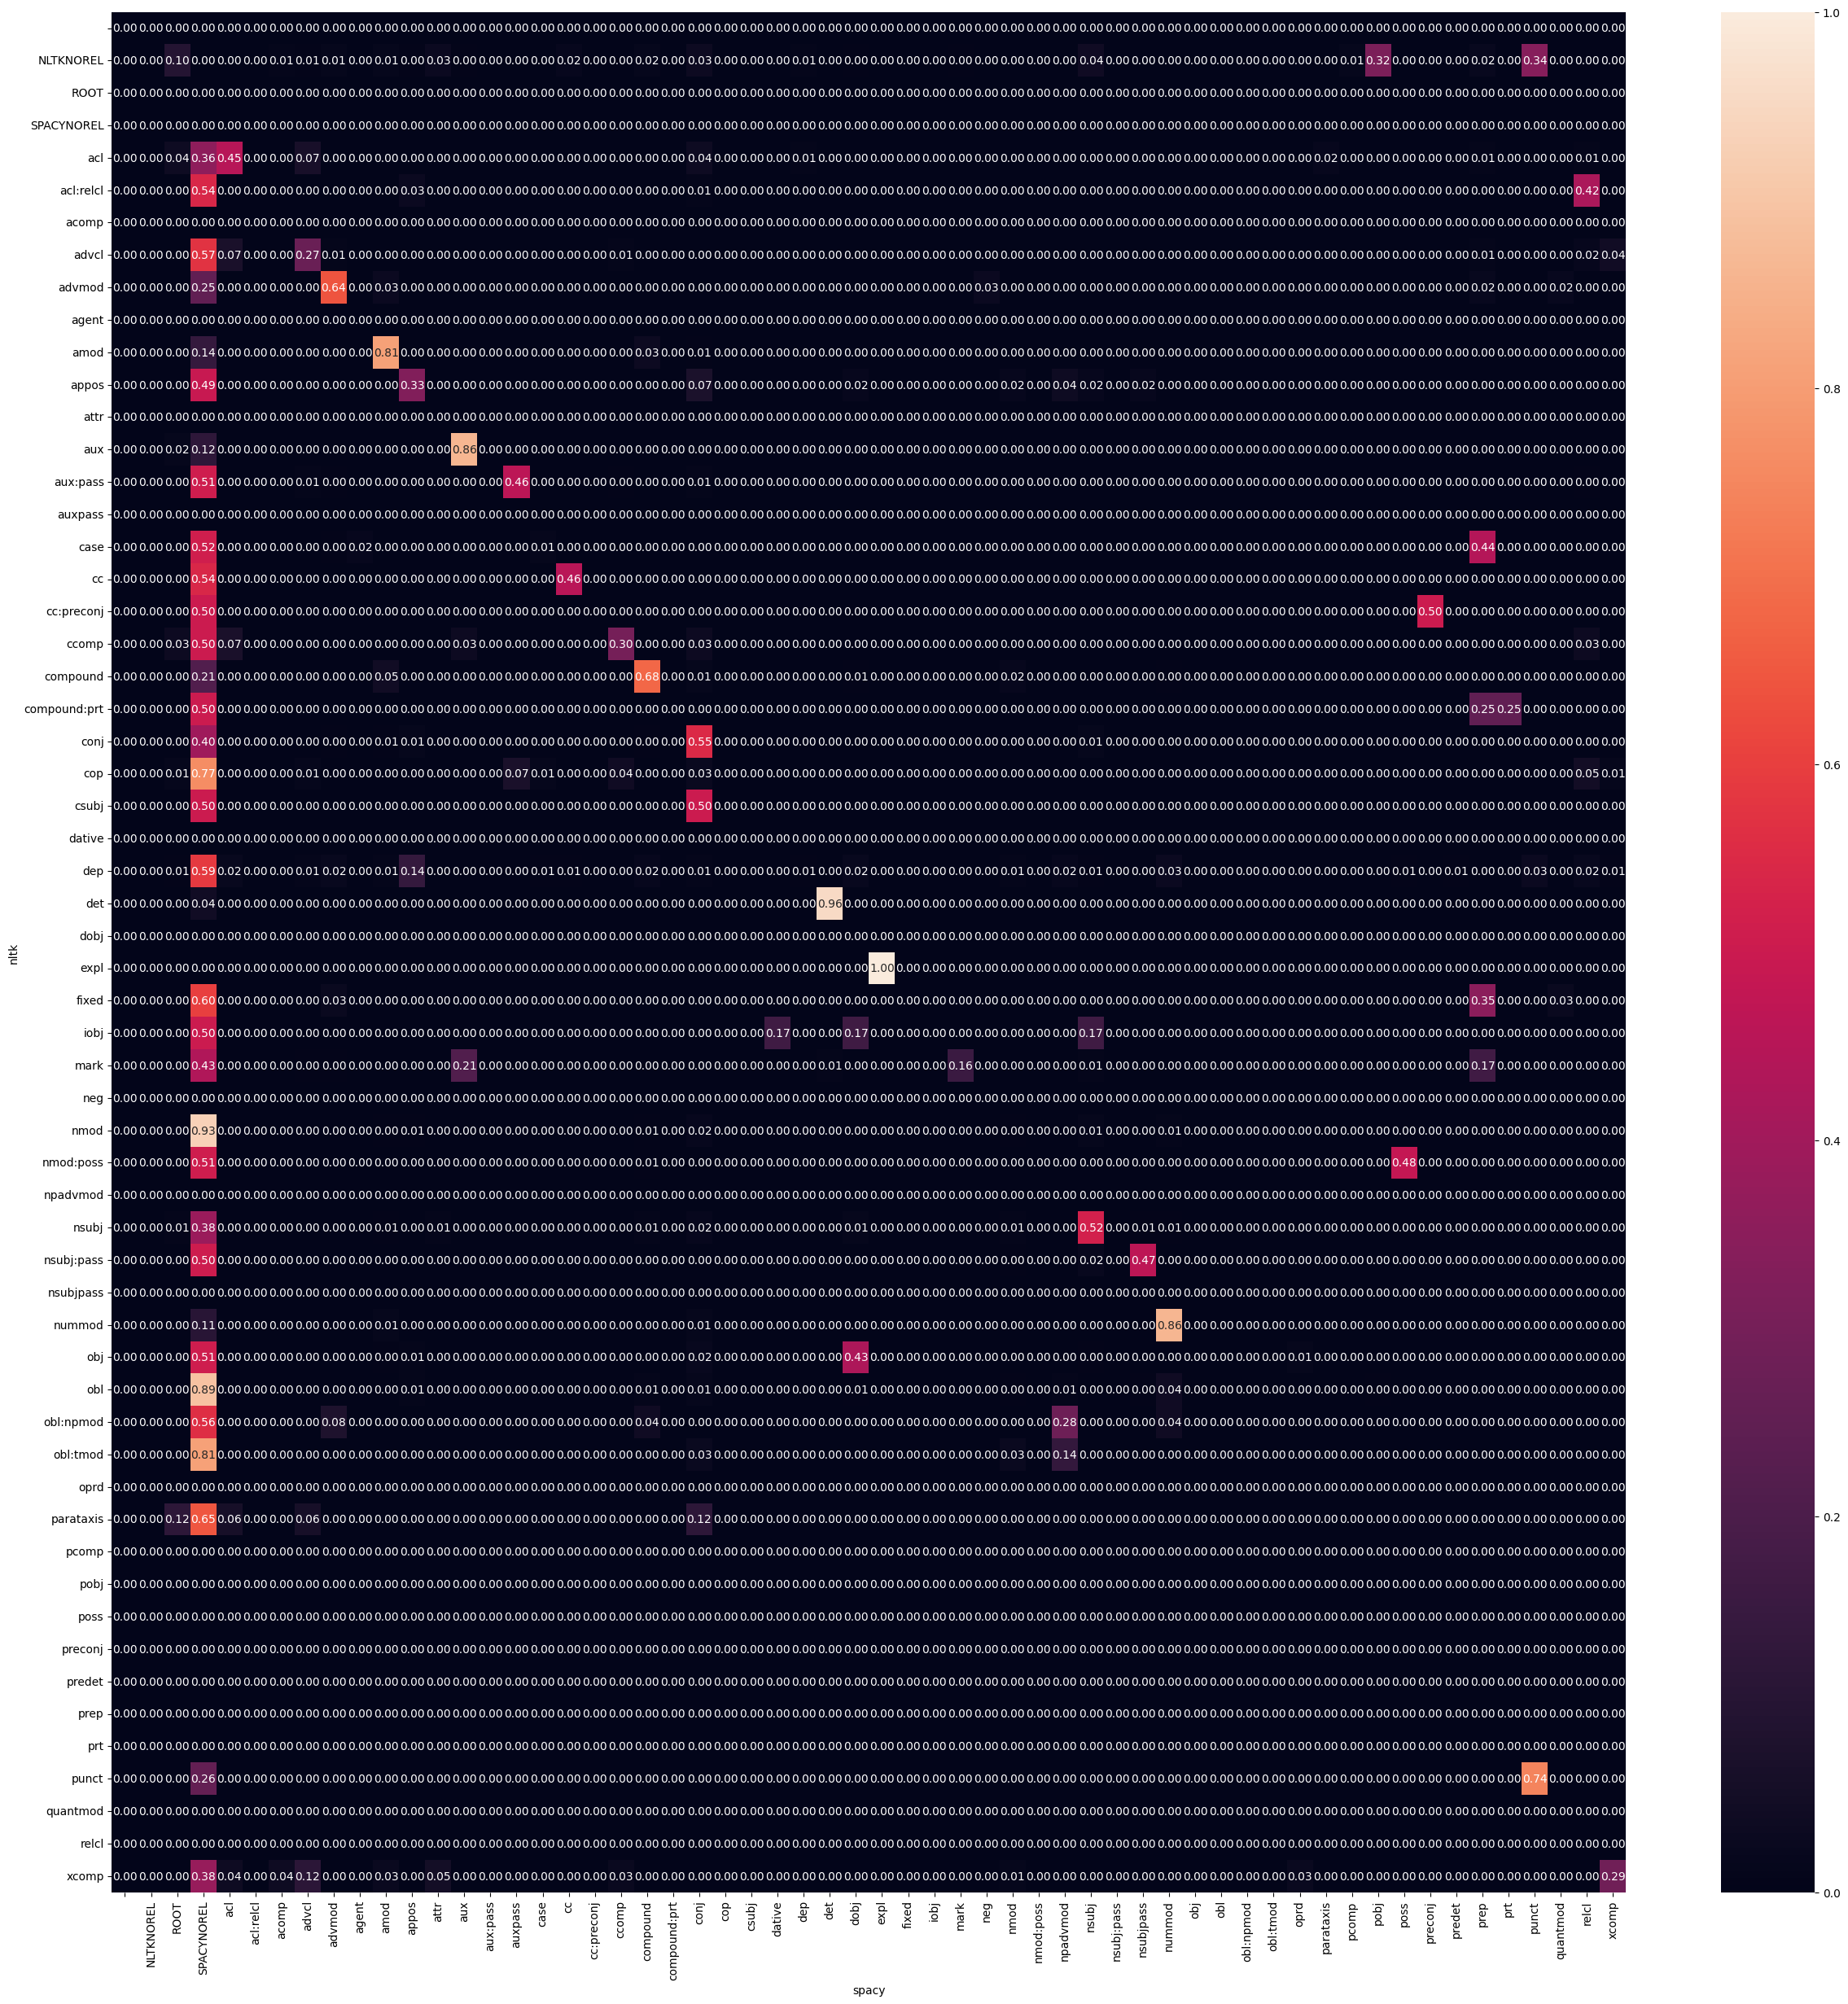

In [100]:
all_rels = shared_rel_in_sentences + not_in_spacy_rels
cm = confusion_matrix(list(zip(*all_rels))[2], list(zip(*all_rels))[3], normalize="true")
cols = sorted(list(set(list(zip(*all_rels))[2]+list(zip(*all_rels))[3])))
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=cols, yticklabels=cols)

plt.ylabel('nltk')
plt.xlabel('spacy')
plt.show(block=False)
